In [8]:
import scienceplots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u


plt.style.use(['science', 'grid', 'bright'])

In [2]:
# ratios for figures

pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
width = 242.26653 
twoc = 513.11743
jour_sizes = {"apj": {"onecol": width*pt, "twocol": twoc*pt}}

my_width = jour_sizes["apj"]["onecol"]
twocol = jour_sizes["apj"]["twocol"]
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2

In [35]:
# set sizes for subplots
# from jwalton https://jwalton.info/Embed-Publication-Matplotlib-Latex/

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [3]:
# read data

df_all_model = pd.read_parquet('../scripts/nway_csc21_gaia3_full_neg_study_dis_niter200.parquet')

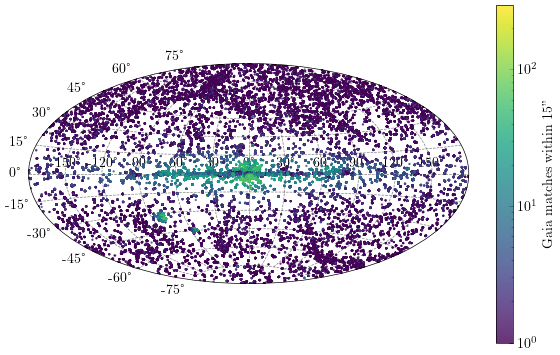

In [ ]:
# Scatter plot: all Chandra sources, colored by number of possible optical matches

# drop duplicates
unique_df = df_all_model.drop_duplicates(subset='csc21_name')

# get galactic coords
coords = SkyCoord(ra=unique_df['csc21_ra'], dec=unique_df['csc21_dec'], unit='degree')
gal = coords.galactic

# convert to radians, wrapping l at 180 deg so that it goes [-pi, +pi]
l = gal.l.wrap_at(180 * u.deg).radian
b = gal.b.radian

# "count" is the number of optical sources within 15"
count_vals = unique_df['count'].values

fig = plt.figure(figsize=(twocol, twocol/golden))
ax = plt.subplot(111, projection='aitoff')

# scatter: color = count
sc = ax.scatter(l, b, c=count_vals, s=0.4,
                cmap='viridis', norm=LogNorm(),
                alpha=0.8)

# colorbar
cb = fig.colorbar(sc, ax=ax)
cb.set_label('Gaia matches within $15"$')

plt.savefig('figures/chandra_optical_sky.pdf', bbox_inches='tight')
plt.show()

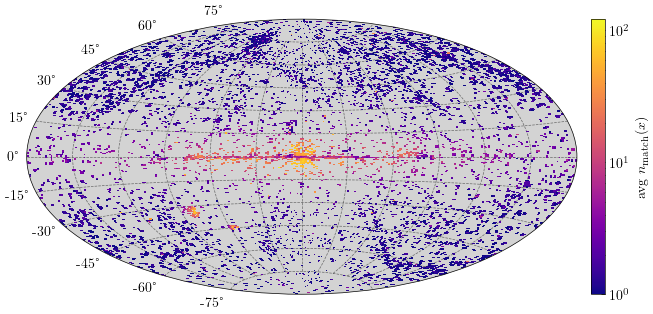

In [34]:
# Heatmap: average number of possible optical matches per X-ray source per bin

# drop duplicates
unique_df = df_all_model.drop_duplicates(subset='csc21_name')

# get galactic coords
coords = SkyCoord(ra=unique_df['csc21_ra'], dec=unique_df['csc21_dec'], unit='degree')
gal = coords.galactic

# convert to radians, wrapping l at 180 deg so that it goes [-pi, +pi]
l = gal.l.wrap_at(180 * u.deg).radian
b = gal.b.radian

# "count" is the number of optical sources within 15"
count_vals = unique_df['count'].values

# histogram in 2D, building the sum of 'count' per bin and the number of points per bin
bins = 300
H_sum, xedges, yedges = np.histogram2d(l, b, bins=bins, weights=count_vals)
H_num, _, _ = np.histogram2d(l, b, bins=[xedges, yedges])  # same edges

# average crowding, ignoring bins that have zero data
with np.errstate(invalid='ignore'):
    avg_crowding = H_sum / H_num  # array with shape (bins, bins)

# define bin centers for pcolormesh
xcenter = 0.5*(xedges[:-1] + xedges[1:])
ycenter = 0.5*(yedges[:-1] + yedges[1:])

# mask or set to NaN the bins with no coverage
avg_crowding[H_num < 1] = np.nan  # so those cells appear blank or a special color

fig = plt.figure(figsize=(twocol, twocol/golden))
ax = plt.subplot(111, projection='aitoff')
ax.set_facecolor('lightgray')  # so "no coverage" stands out if we set nan color to white

# pcolormesh with log color scale
pc = ax.pcolormesh(xcenter, ycenter, avg_crowding.T,  # note .T because histogram2d outputs [x,y]
                   cmap='plasma', norm=LogNorm(), shading='auto')

# delete labels from inside
ax.set_xticklabels([])
ax.set_axisbelow(True)

# colorbar whose height (or width) in sync with the master axes¶
pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.02, pos.y0, 0.02, pos.height])
cbar = fig.colorbar(pc, cax=cax)
cbar.set_label("avg $n_{\\mathrm{match}}(x)$")

plt.savefig('figures/chandra_optical_sky_hist.pdf', bbox_inches='tight')
plt.show()


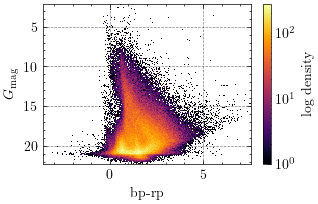

In [ ]:
#bp-rp vs gmag for all sources with match_flag == 1
df_matches_nway = df_all_model[df_all_model['match_flag'] == 1]

# remove rows with NaN values in 'bp_rp' or 'phot_g_mean_mag'
df_matches_nway_clean = df_matches_nway.dropna(subset=['bp_rp', 'phot_g_mean_mag'])

fig, ax = plt.subplots(figsize=(my_width, my_width/golden))

# 2D histogram with logarithmic color scale
hist = ax.hist2d(df_matches_nway_clean['bp_rp'], df_matches_nway_clean['phot_g_mean_mag'], bins=200, cmap='inferno', norm=LogNorm())

# color bar
cb = fig.colorbar(hist[3], ax=ax)
cb.set_label('log density')

ax.set_xlabel('bp-rp')
# latex 'G_{\text{mag}}'
ax.set_ylabel(r'$G_{\mathrm{mag}}$')
ax.invert_yaxis()  # invert y-axis to match the typical astronomical convention
plt.savefig('figures/bp_rp_vs_gmag_density_hist.pdf', bbox_inches='tight')
plt.show()

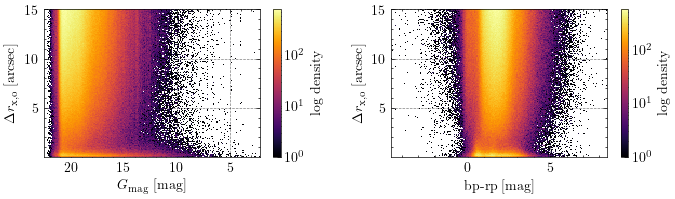

In [62]:
# 1x2 subplots comparing 'separation' vs columns:
# phot_g_mean_mag, bp_rp

fig, axes = plt.subplots(1, 2, figsize=set_size(twoc, fraction=1.0, subplots=(1, 2)))

# 1) separation vs phot_g_mean_mag
ax = axes[0]
df_g_clean = df_all_model.dropna(subset=['phot_g_mean_mag', 'separation'])
hist_g = ax.hist2d(
    df_g_clean['phot_g_mean_mag'],
    df_g_clean['separation'],
    bins=200, cmap='inferno', norm=LogNorm()
)
cb_g = fig.colorbar(hist_g[3], ax=ax)
cb_g.set_label('log density')
ax.set_xlabel(r'$G_{\mathrm{mag}}$ [mag]')
ax.set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')
ax.invert_xaxis()  # invert y-axis to match the typical astronomical convention

# 2) separation vs bp_rp
ax = axes[1]
df_bprp_clean = df_all_model.dropna(subset=['bp_rp', 'separation'])
hist_bprp = ax.hist2d(
    df_bprp_clean['bp_rp'],
    df_bprp_clean['separation'],
    bins=200, cmap='inferno', norm=LogNorm()
)
cb_bprp = fig.colorbar(hist_bprp[3], ax=ax)
cb_bprp.set_label('log density')
ax.set_xlabel('bp-rp [mag]')
ax.set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')

plt.tight_layout()
plt.savefig('figures/separation_vs_params_density_hist_gaia.pdf', bbox_inches='tight')
plt.show()

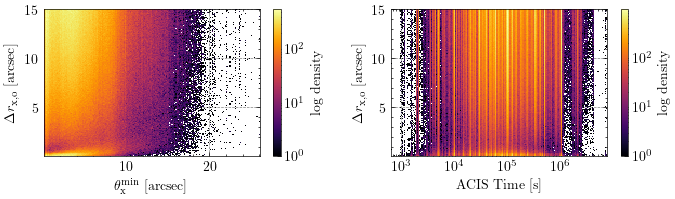

In [61]:
# 1x2 subplots comparing 'separation' vs columns:
# min_theta_mean, acis_time

fig, axes = plt.subplots(1, 2, figsize=set_size(twoc, fraction=1.0, subplots=(1, 2)))

# 3) separation vs min_theta_mean
ax = axes[0]
df_theta_clean = df_all_model.dropna(subset=['min_theta_mean', 'separation'])
hist_theta = ax.hist2d(
    df_theta_clean['min_theta_mean'],
    df_theta_clean['separation'],
    bins=200, cmap='inferno', norm=LogNorm()
)
cb_theta = fig.colorbar(hist_theta[3], ax=ax)
cb_theta.set_label('log density')
ax.set_xlabel(r'$\theta^{\mathrm{min}}_{\mathrm{x}}$ [arcsec]')
ax.set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')


# 4) separation vs acis_time
ax = axes[1]
df_acis_clean = df_all_model.dropna(subset=['acis_time', 'separation'])
xmin, xmax = df_acis_clean['acis_time'].min(), df_acis_clean['acis_time'].max()
# make logarithmically spaced bins for the x-axis
xbins = np.logspace(np.log10(xmin), np.log10(xmax), 200)
hist_acis = ax.hist2d(
    df_acis_clean['acis_time'],
    df_acis_clean['separation'],
    bins=[xbins, 200],
    cmap='inferno', norm=LogNorm()
)
cb_acis = fig.colorbar(hist_acis[3], ax=ax)
cb_acis.set_label('log density')
ax.set_xlabel('ACIS Time [s]')
ax.set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('figures/separation_vs_params_density_hist_chandra.pdf', bbox_inches='tight')
plt.show()